In [ ]:
@RAVISHEEL

# Install dependencies

In [1]:
# !pip install pinecone-client
# !pip install torchsummary
# !pip install pandas numpy matplotlib

# Import Libraries

In [2]:
from torchsummary import summary
import pinecone
import os
from tqdm.autonotebook import tqdm
from torchvision import datasets
import random
import matplotlib.pyplot as plt
from PIL import Image

/Users/ravisheel/anaconda3/lib/python3.10/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import torch
from torchvision import transforms
import numpy as np
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from tqdm import tqdm
import pandas as pd


# Get Pinecone Free API Key

In [5]:
api_key = os.getenv("api_key") or "your-api-key"
pinecone.init(api_key=api_key)

# I have used Tiny ImageNet Dataset http://cs231n.stanford.edu/tiny-imagenet-200.zip  which has 100,000 training images from 200 classes each

In [6]:
random_seed = 123
random.seed(random_seed)


image_classes = set(random.sample(range(200), 5))

image_file_names = [ file_name for file_name, label in datasets.ImageFolder("/Users/ravisheel/Data/images").imgs
                    if label in image_classes ]

In [1]:
# image_file_names[:10]

In [8]:
len(image_file_names)

2500

# Functions for displaying the images

In [9]:
def show_images_horizontally(file_names):
    m = len(file_names)
    fig, ax = plt.subplots (1, m)
    fig.set_figwidth(1.5 * m)
    for a, f in zip(ax, file_names):
        a.imshow(Image.open(f))
        a.axis("off")
    plt.show()




def show_image (file_name):
    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(1.3)
    ax.imshow(Image. open(file_name))
    ax.axis("off")

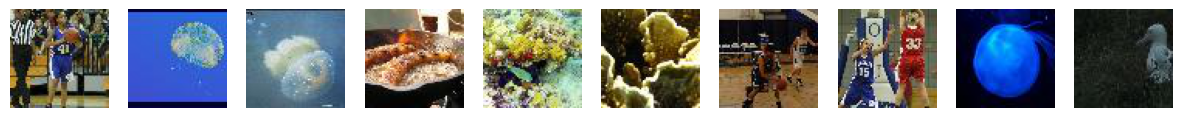

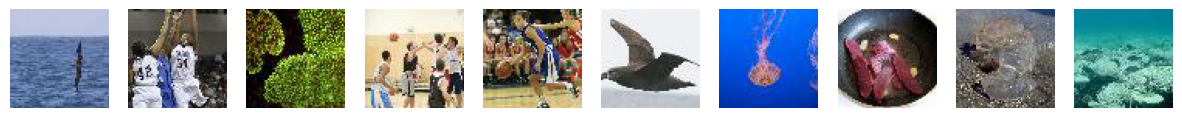

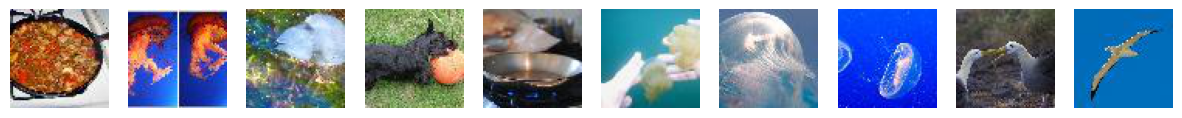

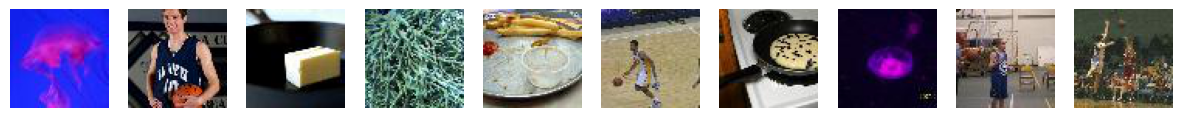

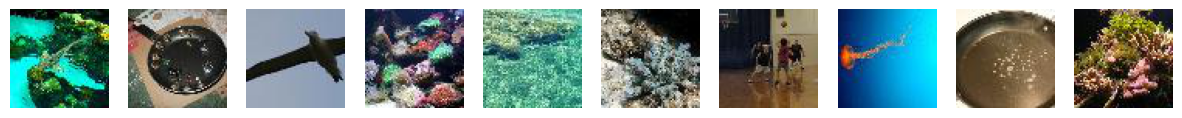

In [10]:
for i in range(5):
    show_images_horizontally(random.sample(image_file_names, 10))

In [11]:
image = Image.open('/Users/ravisheel/Data/images/n01910747_100.JPEG')
width, height = image.size
print(f"Image width: {width}, height: {height}")

Image width: 64, height: 64


# Here I'm using pre trained neural network name squeezenet v1 from torchvision. 

## Squeezenet basically converts an image into vector embedding by flattening it

## Pinecone vector database can store upto 20000 dimensions of vector, So here I have limit the dimensions of vector till 20000.

In [12]:
class ImageEmbedding:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.model = models.squeezenet1_0(pretrained=True, progress=False)
        self.model = nn.Sequential(*list(self.model.children())[:-1]) # here i removed its last layer

    def embed(self, image_file_names, target_size=20000): # here embedding performs
        image = Image.open(image_file_names).convert("RGB")
        image = transforms.Resize(256)(image)
        image = transforms.CenterCrop(224)(image)
        tensor = transforms.ToTensor()(image)
        tensor = self.normalize(tensor).reshape(1,3,224,224)  

        
        with torch.no_grad():
            embeddings = self.model(tensor)

        flattened_embeddings = embeddings.squeeze().cpu().numpy().flatten()

        flattened_embeddings = flattened_embeddings[:target_size]

        return flattened_embeddings # this flattened_embeddings contains input image with size 20000

image_embeddings = ImageEmbedding()

/Users/ravisheel/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ravisheel/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
df = pd.DataFrame()

df ["image_file_name"] = image_file_names
df ["embedding_id"] = pd.Series(file_name.split("/Users/ravisheel/Data/images/train") [-1] for file_name in image_file_names)

df["embedding"] =  pd.Series(image_embeddings.embed(file_name) for file_name in tqdm(image_file_names))

df = df.sample(frac=1)

100%|███████████████████████████████████████| 2500/2500 [01:00<00:00, 41.14it/s]


In [14]:
df.head(2)

image_file_name  \
2216  /Users/ravisheel/Data/BU/MET CS 777 Big Data A...   
96    /Users/ravisheel/Data/BU/MET CS 777 Big Data A...   

                              embedding_id  \
2216  /n09256479/images/n09256479_293.JPEG   
96    /n01910747/images/n01910747_185.JPEG   

                                              embedding  
2216  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
96    [0.0, 0.0, 0.0, 13.924885, 0.0, 0.0, 0.0, 0.0,...

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 2216 to 1167
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_file_name  2500 non-null   object
 1   embedding_id     2500 non-null   object
 2   embedding        2500 non-null   object
dtypes: object(3)
memory usage: 78.1+ KB


In [16]:
df.iloc[2082, 2].shape


(20000,)

# Here I'm splitting df into item_df and query_df, where all the  item_df embedding_id and embedding will store into vector databse with ids and values, and will use query_df to query the embedding in the vector DB

In [17]:
cutoff = int(len(df) * 0.90)

item_df, query_df = df[:cutoff], df[cutoff:]

print(item_df. shape, query_df. shape)

(2250, 3) (250, 3)


# Before uploading all the data into Pinecone DB we need to manually create indexes in pinecone, where we have to choose the dimension size and the metric (cosine, dotproduct, euclidean). 

# For this image similarity search I'm using Cosine Similarity to find nearest vector embeddings because I have a large dimension

### Now I'm upserting i.e.. uploading id and their respective vectors to Pinecone 

In [18]:
import pinecone      

pinecone.init(      
	api_key='your-api-key',      
	environment='gcp-starter'      
)      
index = pinecone.Index('imgsimilarity')

In [19]:
for i, row in item_df.iterrows():
    upsert_data = {
        'id': row['embedding_id'],
        'values': row['embedding']
    }
    index.upsert(vectors=[upsert_data])

/Users/ravisheel/anaconda3/lib/python3.10/site-packages/pinecone/core/utils/__init__.py:113: FutureWarning: DEPRECATED since v2.2.1 [Will be removed in v3.0.0]: Deprecated type passed in 'values'. The ability to pass a numpy ndarray as part of a dictionary argument to upsert() will be removed in a future version of the pinecone client. To remove this warning, use the numpy.ndarray.tolist method to convert your ndarray into a python list before calling upsert().
  warnings.warn(message, FutureWarning)


In [2]:
# query_df.head(2)

### Here I'm storing all the query_dfs' vectors into a list inorder to query the pinecone DB, because it takes 1 vector at a time to query the DB

In [21]:
vector22 = query_df.iloc[:,2].tolist()
list_of_lists = [vector.tolist() for vector in vector22]

print(len(list_of_lists))

250


### Here I'm performing my Query 

In [22]:
final_res = []
for i in range(0,len(query_df)):
    res = index.query(vector = list_of_lists[i], top_k=10 )
    final_res.append(res)
    

Query 91 and search resulta


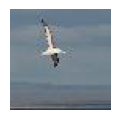

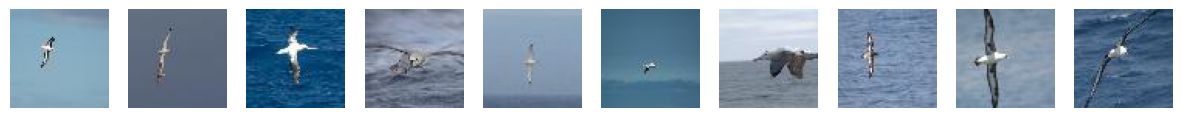

------------------------------------------------------------------------------------------
Query 92 and search resulta


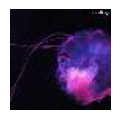

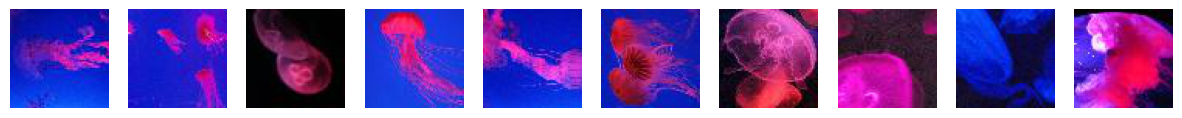

------------------------------------------------------------------------------------------
Query 93 and search resulta


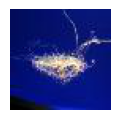

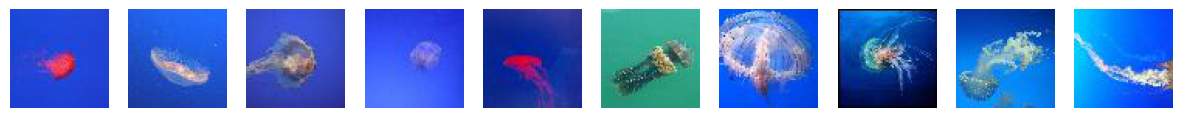

------------------------------------------------------------------------------------------
Query 94 and search resulta


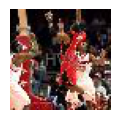

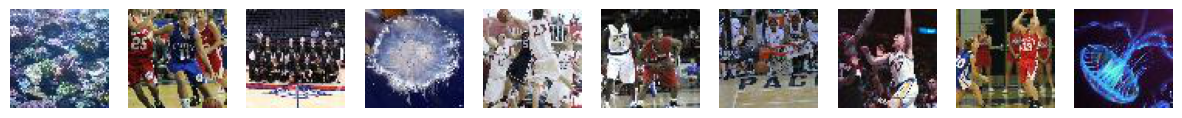

------------------------------------------------------------------------------------------
Query 95 and search resulta


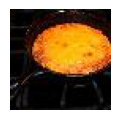

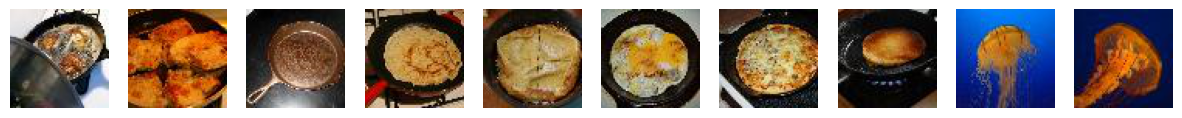

------------------------------------------------------------------------------------------
Query 96 and search resulta


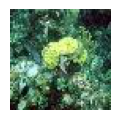

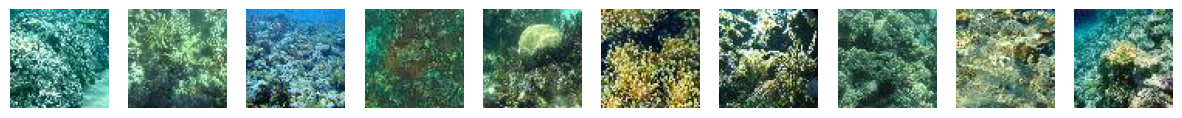

------------------------------------------------------------------------------------------
Query 97 and search resulta


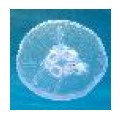

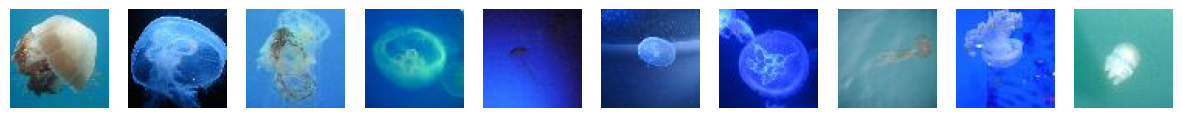

------------------------------------------------------------------------------------------
Query 98 and search resulta


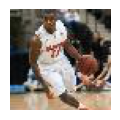

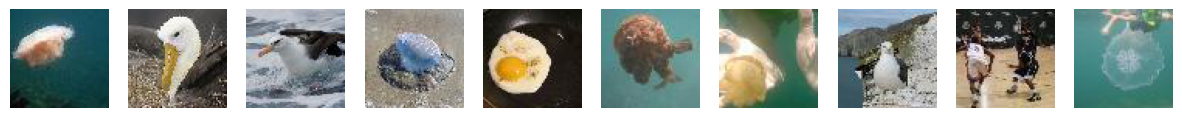

------------------------------------------------------------------------------------------
Query 99 and search resulta


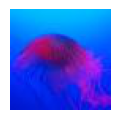

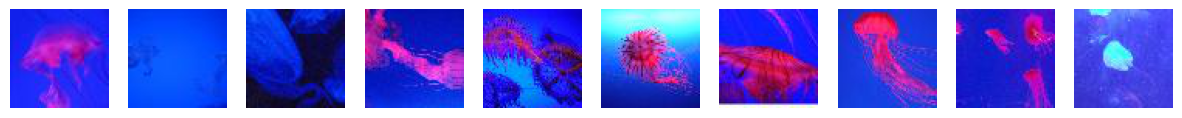

------------------------------------------------------------------------------------------
Query 100 and search resulta


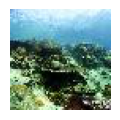

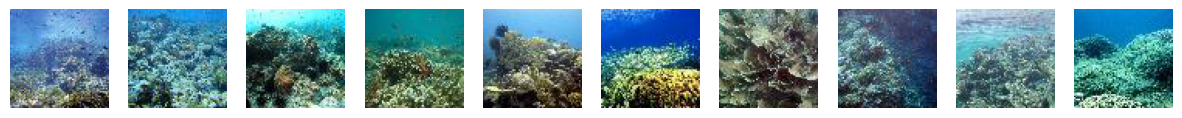

------------------------------------------------------------------------------------------
Query 101 and search resulta


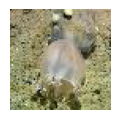

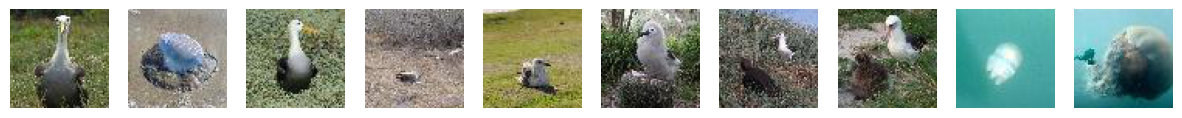

------------------------------------------------------------------------------------------
Query 102 and search resulta


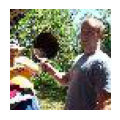

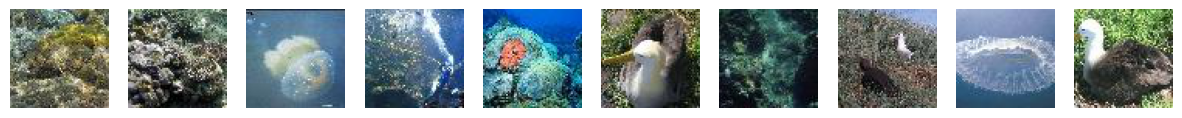

------------------------------------------------------------------------------------------
Query 103 and search resulta


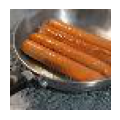

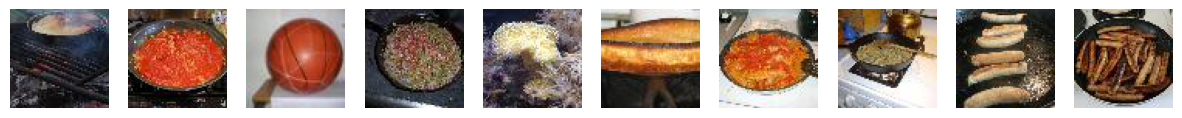

------------------------------------------------------------------------------------------
Query 104 and search resulta


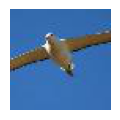

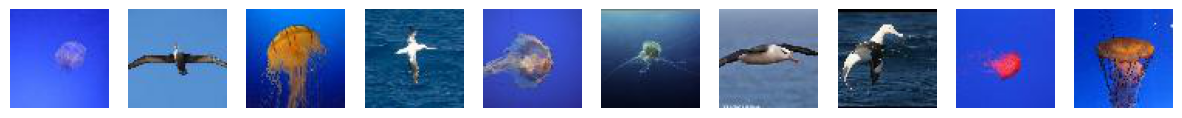

------------------------------------------------------------------------------------------
Query 105 and search resulta


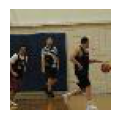

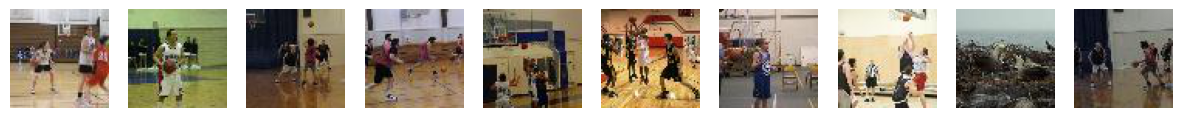

------------------------------------------------------------------------------------------
Query 106 and search resulta


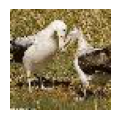

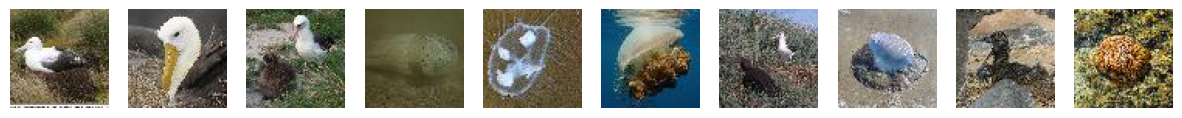

------------------------------------------------------------------------------------------
Query 107 and search resulta


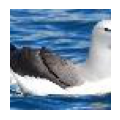

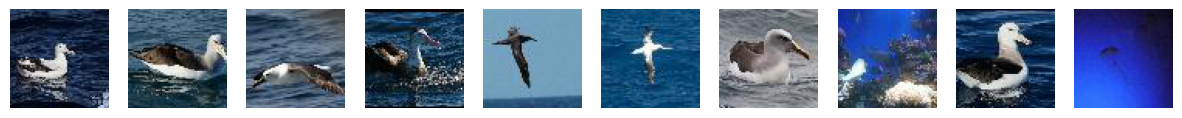

------------------------------------------------------------------------------------------
Query 108 and search resulta


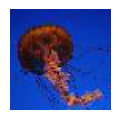

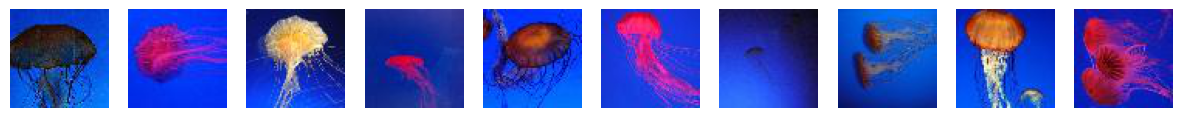

------------------------------------------------------------------------------------------
Query 109 and search resulta


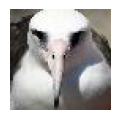

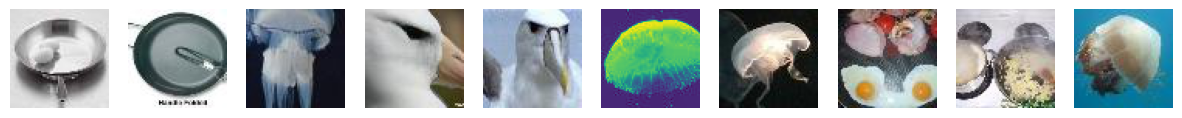

------------------------------------------------------------------------------------------
Query 110 and search resulta


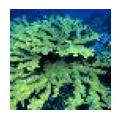

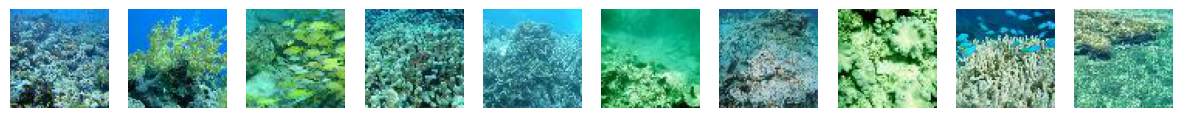

------------------------------------------------------------------------------------------


In [23]:
img_dir = "/Users/ravisheel/Data/images/test"

for i in range(90, 110):
    print(f"Query {i + 1} and search resulta")
    show_image(query_df.image_file_name.iloc[i])
    show_images_horizontally( [img_dir +  match['id'] for match in final_res[i]['matches']] )
    print("-"* 90)